# Data Processing Pipeline to Train ML Models

In [1]:
import h2o
import os, requests

import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from PipelineComponents import RemoveColumns, CastToInt, CleanUp
from pysparkling import H2OContext
from pysparkling.ml import H2OAutoML
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
spark = SparkSession.builder.appName("GitStarred").config("spark.jars.packages", "org.postgresql:postgresql:42.2.14").config("spark.executor.memory", "13g").config("spark.driver.memory", "13g").getOrCreate()

## Importing Data
To reduce computational requirements, we use a small random subset of values for tests.
A seed is used for reusability.

To run on the full database, use the commented out code.

In [3]:
# raw_data = spark.read.jdbc("jdbc:postgresql:GitHubData", "Repositories", properties={"user": "program", "password": "DatabaseAccess", "driver": "org.postgresql.Driver"})
query = "(SELECT * FROM Repositories TABLESAMPLE SYSTEM(10) REPEATABLE(1)) AS temp"
raw_data = spark.read.jdbc("jdbc:postgresql:GitHubData", query, properties={"user": "program", "password": "DatabaseAccess", "driver": "org.postgresql.Driver"})

## Exploratory Analysis
We can start by viewing our columns and their relative data types.
Look at one at a time and notice how they're similar or different to our natural expectations.
Whilst doing this we'll notice that some features are now useless, some are very similar to others, and a few will far more effort to handle than others.

*Note that showing values slows down the run on moderately sized data, so is commented out by default.*

In [4]:
raw_data.printSchema()
print(f"{raw_data.count()} rows")
# raw_data.show(vertical=True)

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- topics: string (nullable = true)
 |-- license: string (nullable = true)
 |-- readme: string (nullable = true)
 |-- primarylanguage: string (nullable = true)
 |-- createddate: timestamp (nullable = true)
 |-- lastpusheddate: timestamp (nullable = true)
 |-- fork: boolean (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- forkcount: long (nullable = true)
 |-- commits: long (nullable = true)
 |-- issues: long (nullable = true)
 |-- pullrequests: long (nullable = true)
 |-- users: long (nullable = true)
 |-- watchs: long (nullable = true)
 |-- stars: long (nullable = true)

4472070 rows


The first thing we can do is get rid of alternative popularity metrics like fork count and watch count (which won't be used).

In [5]:
drop = RemoveColumns("id", "forkcount", "watchs", "users", "issues", "pullrequests")

The next thing we can see is that both textual and categorical values are encoded as strings.
We luckily don't have to modify categorical strings, as H2O can naturally interpret them.
However, actual text (i.e. readmes and descriptions) are far more complicated and so we need to convert them into a numeric representation (through natural language processing techniques) later on.

*Note that most ML libraries like MLLib can't interpret categories, and so require conversion to numeric values (normally through a `StringIndexer` or `OneHotEncoder`).*

Remember that boolean values should be manually converted to integers (0's and 1's) to avoid any problems later during testing.

In [6]:
cast_to_int = CastToInt("fork", "locked", "archived")

We can take a look at our categorical columns distribution of values (for language and license) now

In [7]:
print(f"Unique Languages: {raw_data.select('primarylanguage').distinct().count()}")
raw_data.groupby("primarylanguage").count().sort(F.desc("count")).show()
print(f"Unique Licenses: {raw_data.select('license').distinct().count()}")
raw_data.groupby("license").count().sort(F.desc("count")).show()

Unique Languages: 363
+----------------+-------+
| primarylanguage|  count|
+----------------+-------+
|            null|1373014|
|      JavaScript| 597934|
|            Java| 488969|
|            HTML| 428438|
|          Python| 308990|
|             CSS| 142406|
|             PHP| 137119|
|              C#| 132909|
|             C++| 118971|
|            Ruby|  83194|
|               C|  78288|
|Jupyter Notebook|  76810|
|      TypeScript|  74209|
|           Shell|  57242|
|           Swift|  48037|
|              Go|  36417|
|     Objective-C|  25818|
|               R|  25606|
|             Vue|  19566|
|          Kotlin|  18310|
+----------------+-------+
only showing top 20 rows

Unique Licenses: 38
+------------+-------+
|     license|  count|
+------------+-------+
|        null|3865370|
|         mit| 305752|
|  apache-2.0|  82900|
|     gpl-3.0|  80891|
|       other|  78213|
|     gpl-2.0|  13578|
|bsd-3-clause|   9130|
|   unlicense|   7872|
|    agpl-3.0|   5484|
|    lgp

## Min-Max Feature Scaling
For the sake of interpretability, the number of stars a repository has is scaled between 0 and 1.
This essentially means that the least popular repositories have 0% popularity and most popular 100%.

In [8]:
assembler = VectorAssembler(inputCols=["stars"], outputCol="starsVector")
scaler = MinMaxScaler(inputCol="starsVector", outputCol="target")

## Text Features
There are several text fields to deal with:
* Name
* Description
* Topics
* README

To start off with we don't *know for sure* what will be most useful for our model (yet), and it tends to be computationally expensive to process every feature here.
Hence, we can start with what seems reasonable.

*Note that **work on the text hasn't yet begun, so all text features have been temporarily removed**.*

People remember names, but names are also extremely sparse (i.e. names are normally only used once per project) and so they'll be hard to process.
Topics tend to be categories like programming language and technology stack was used.
They're likely useful, but it's probably best to just use the primary programming language field for now.
Descriptions and read readmes are the first thing anyone sees from a project (and first impressions count).
Descriptions are short and so should be relatively easy to deal with, but are equally vague.
Readme's tend to be very long... but it's likely the rough outlines (i.e. headings) along with the first few paragraphs convey what the project is about.
It is possible that all features are valuable, but the computational power needed to analyse them using deep learning techniques would be too great.

In [9]:
raw_data = raw_data.drop("name", "description", "topics", "readme")

## Create and Run Pipeline
Chain all the data processing processes together into the one pipeline!
The final data is divided into training and testing datasets.

In [10]:
cleanup = CleanUp("target")

In [11]:
pipeline = Pipeline(stages=[drop, assembler, scaler, cast_to_int, cleanup])
data = pipeline.fit(raw_data).transform(raw_data)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1)

In [12]:
data.show()

+-------+----------------+-------------------+-------------------+----+--------+------+-------+--------------------+
|license| primarylanguage|        createddate|     lastpusheddate|fork|archived|locked|commits|              target|
+-------+----------------+-------------------+-------------------+----+--------+------+-------+--------------------+
|   null|              Go|2016-06-18 00:00:06|2016-06-18 01:44:27|   0|       0|     0|      2|                 0.0|
|   null|          Python|2016-06-18 00:30:21|2016-06-20 01:37:19|   0|       0|     0|     19|                 0.0|
|   null|            HTML|2016-06-18 00:31:21|2016-06-21 22:53:20|   0|       0|     0|     19|                 0.0|
|   null|               C|2016-06-18 00:33:36|2016-06-18 00:43:46|   0|       0|     0|     10|                 0.0|
|   null|            HTML|2016-06-18 00:37:56|2016-06-18 00:43:34|   0|       0|     0|      1|                 0.0|
|   null|            null|2016-06-18 00:47:48|2016-06-18 00:47:4

## Modelling
Start H2O, train as many models as possible and show results (including a variable importance plot).
The plot is for the *best model which provides variable importance* (typically not the best model as `StackedEnsemble`'s do not).

In [13]:
H2OContext.getOrCreate()

Connecting to H2O server at http://207.148.81.217:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,19 days
H2O_cluster_name:,sparkling-water-kamron_local-1597069269346
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,11.56 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.30.0.7-1-3.0
 * H2O name: sparkling-water-kamron_local-1597069269346
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,207.148.81.217,54321)
  ------------------------

  Open H2O Flow in browser: http://207.148.81.217:54323 (CMD + click in Mac OSX)

    

Sparkling Water Context:
 * Sparkling Water Version: 3.30.0.7-1-3.0
 * H2O name: sparkling-water-kamron_local-1597069269346
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,207.148.81.217,54321)
  ------------------------

  Open H2O Flow in browser: http://207.148.81.217:54323 (CMD + click in Mac OSX)

    


In [14]:
automl = H2OAutoML(maxRuntimeSecs=120, labelCol="target", convertUnknownCategoricalLevelsToNa=True, convertInvalidNumbersToNa=True, seed=1)
model = automl.fit(train_data)
results = model.transform(test_data)

In [15]:
results.show()
automl.getLeaderboard().show(truncate=False)

+-------+---------------+-------------------+-------------------+----+--------+------+-------+------+--------------------+
|license|primarylanguage|        createddate|     lastpusheddate|fork|archived|locked|commits|target|          prediction|
+-------+---------------+-------------------+-------------------+----+--------+------+-------+------+--------------------+
|   null|           null|2016-01-01 00:04:41|2016-01-01 00:04:41|   0|       0|     0|      0|   0.0|-2.72132562657005E-5|
|   null|           null|2016-01-01 00:31:22|2016-08-04 15:17:18|   0|       0|     0|      6|   0.0|-1.55999760461598...|
|   null|           null|2016-01-01 01:20:04|2016-01-01 01:20:05|   0|       0|     0|      1|   0.0|-2.72104492966872...|
|   null|           null|2016-01-01 01:23:40|2016-01-01 01:23:40|   0|       0|     0|      0|   0.0|-2.72103158974083...|
|   null|           null|2016-01-01 01:25:06|2016-06-26 01:26:57|   0|       0|     0|     13|   0.0|-1.77215960262445...|
|   null|       

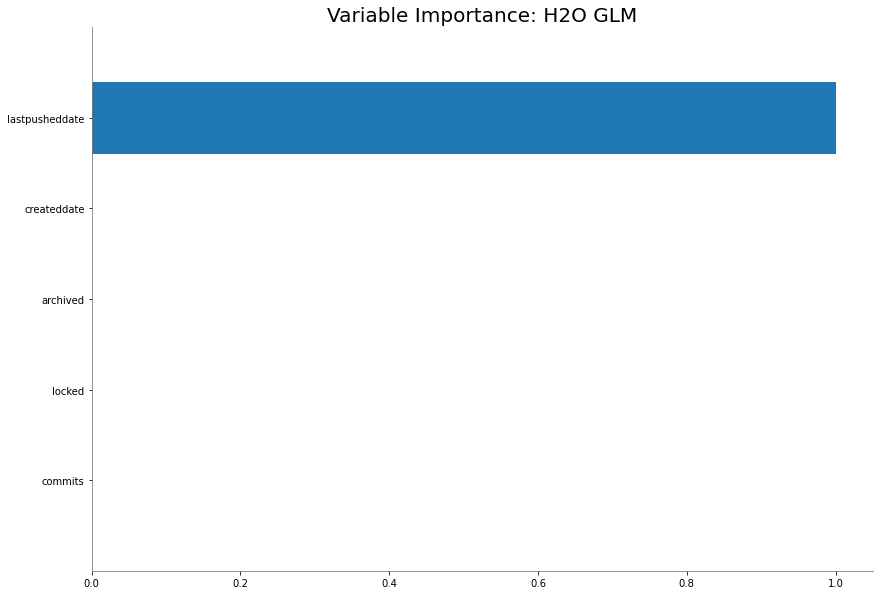

In [16]:
def var_imp(model_id):
    try: h2o.get_model(model_id).varimp_plot();
    except: return False

for model in automl.getLeaderboard().collect():
    if var_imp(model["model_id"]) != False: break